# Kanapy – Script to generate abaqus input files with boundary conditions.
Generate a representatative volume element (RVE) for a synthetic microstructure and export geometry as Abaqus INP file. The boundary conditions are stress or strain based and given to include periodic or non periodic boundary conditions. 

Author: Alexander Hartmaier, ICAMS / Ruhr-University Bochum, Germany 

Copyright © by the author, August 2025

### 1. Import required libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import kanapy as knpy
from math import pi
if int(knpy.__version__[0]) < 6 or int(knpy.__version__[2]) < 1:
    raise ModuleNotFoundError(f'Kanapy version 6.1. or higher is required. Current version is {knpy.__version__}. Please update Kanapy')
print(f'Kanapy version {knpy.__version__}')

Kanapy version 6.5.3


### 2. Generate geometric representation of microstructure

For further details about this part, kindly refer to the example 'generate_rve.ipy' 

In [2]:
matname = 'Austenite fcc'
matnumber = 4  # UMAT number for fcc Iron
deg = pi/180.0

# RVE and microstructure parameters
Nv = 30  # number of voxels along each Cartesian direction
size = 40  # size of RVE in micron
periodic = True  # periodicity of microstructure
ms_elong = {'Grain type': 'Elongated',
          'Equivalent diameter': {'sig': 0.8, 'scale': 14.0, 'cutoff_min': 8.0, 'cutoff_max': 18.0},
          'Aspect ratio': {'sig':0.8, 'scale': 1.5, 'cutoff_min': 0.9, 'cutoff_max': 3.5},
          'Tilt angle': {'kappa': 1.0, 'loc': 90.*deg, "cutoff_min": 0.0, "cutoff_max": 180.0*deg},
          'RVE': {'sideX': size, 'sideY':size, 'sideZ': size, 'Nx': Nv, 'Ny': Nv, 'Nz': Nv, 'ialloy': matnumber},
          'Simulation': {'periodicity': periodic, 'output_units': 'um'},
          'Phase': {'Name': matname, 'Number': 0, 'Volume fraction': 1.0}}

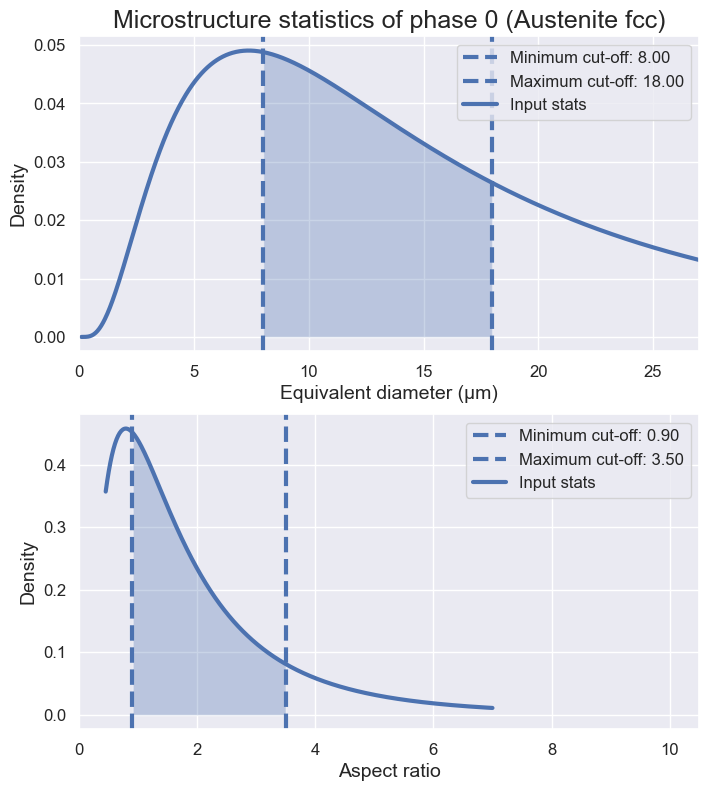

Creating an RVE based on user defined statistics
    Analyzed statistical data for phase Austenite fcc (0)
    Total number of particles  = 56
  RVE characteristics:
    RVE side lengths (X, Y, Z) = (40, 40, 40) (um)
    Number of voxels (X, Y, Z) = (30, 30, 30)
    Voxel resolution (X, Y, Z) = [1.3333 1.3333 1.3333](um)
    Total number of voxels     = 27000


Considered phases (volume fraction): 
0: Austenite fcc (100.0%)


Starting particle simulation
    Creating particles from distribution statistics
    Total volume of generated ellipsoids: 66154.81471275583
    Particle packing by growth simulation
Volume of simulation box: 64000
Volume of unscaled particles: 66154.81471275583
Initial volume of scaled ellipsoids: 66.15481471275585, targeted final volume: 43000.629563291295
Volume increment per time step: 66.15481471275584


100%|███████████████████████████████████████| 1441/1441 [00:17<00:00, 82.14it/s]


Actual final volume of ellipsoids: 42942.69861079759
Completed particle packing
196 overlapping particles detected after packing
Kinetic energy of particles after packing: 371766.9650310292



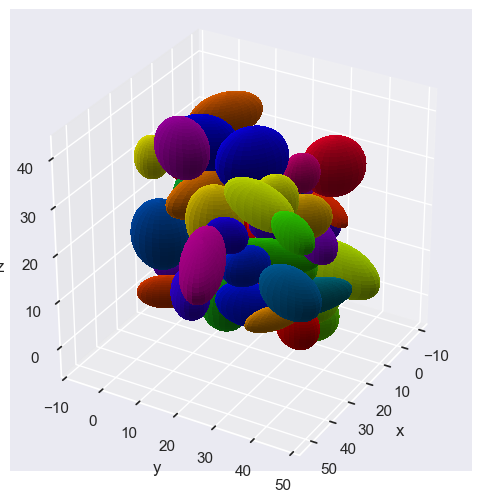

    Generating voxels inside RVE

Starting RVE voxelization
    Assigning voxels to grains


100%|███████████████████████████████| 27000/27000 [00:00<00:00, 50828639.14it/s]


Completed RVE voxelization



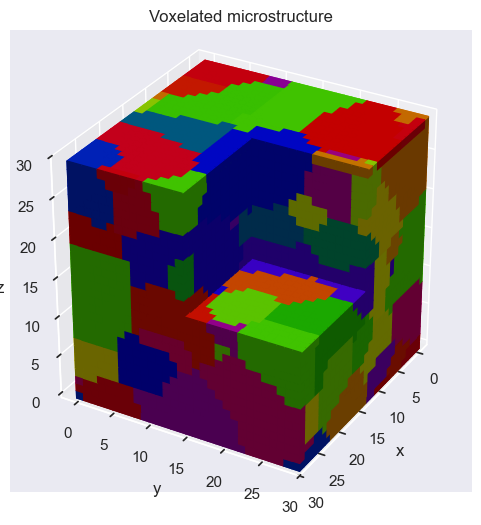

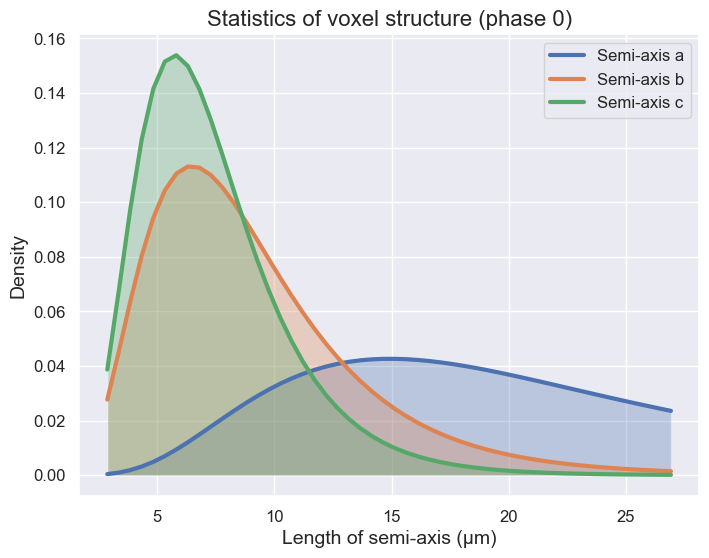


Statistical microstructure parameters of RVE
--------------------------------------------
Type	| a (µm) 	| b (µm) 	| c (µm) 	| std.dev	| rot.axis	| asp.ratio	| std.dev	| equ.dia. (µm)	| std.dev
Input	|  -      	|  -      	|  -      	|   -      	|     -   	|  1.500	|  0.8000	|     14.000 	|  0.8000
Output	|  20.006	|  8.196	|  6.819	|  0.4794	|     0   	|  2.665	|  0.5319	|     17.807 	|  0.4406


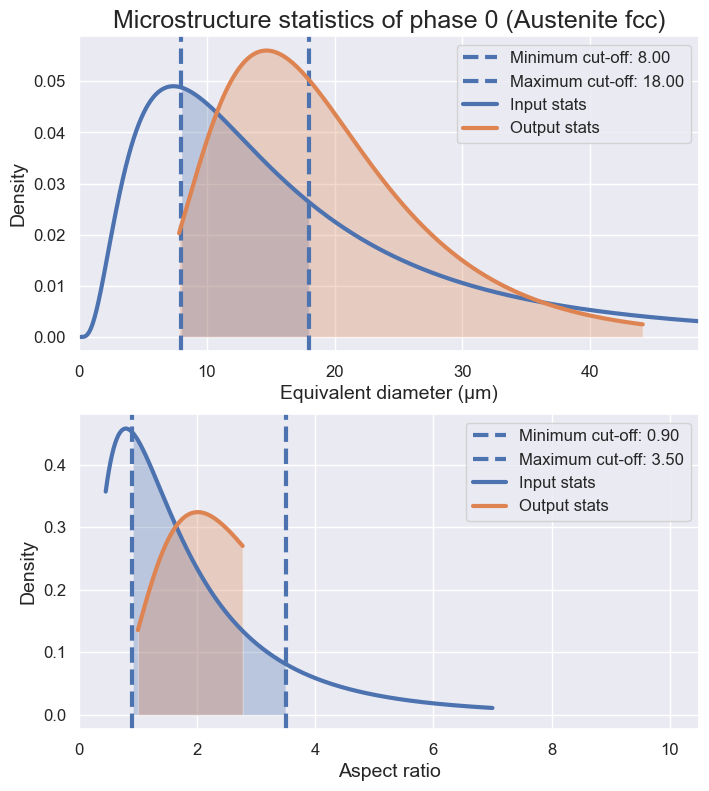

In [3]:
ms = knpy.Microstructure(descriptor=ms_elong, name=matname)
ms.plot_stats_init()  # plot initial statistics of equivalent grain diameter and aspect ratio
ms.init_RVE()  # initialize RVE including particle distribution
ms.pack()  # perform particle simulation to distribute grain nuclei in RVE volume
ms.plot_ellipsoids()  # plot final configuration of particles
ms.voxelize()  # create structured mesh and assign voxels to grains according to particle configuration
ms.plot_voxels(sliced=True)  # plot voxels colored according to grain number
ms.plot_stats_init(show_res=True)  # compare final grain statistics with initial parameters

### 3. Generating the Abaqus input file with boundary conditions. 

The application of boundary conditions in Kanapy's `export2abaqus` function is handled through the `ms.write_abq` method, where loads are set using the `value` parameter as a list of six elements `[XX, YY, ZZ, XY, XZ, YZ]`. Stress loads are defined with numerical values, like putting a number in one direction and zeros elsewhere, while strain loads use a percentage value (for example 0.1 for 10%) with `'*'` for the other directions, such as percentage value in one spot and asterisks for the rest.we Periodic boundary conditions are applied by setting `periodicBC=True`, which links opposite faces with `*Equation` cards, while non-periodic conditions are set with `periodicBC=False`, fixing one side and loading the other. Stress is applied as distributed load `*Dsload` on the respective face for non-periodic cases. While for Periodic ones a concentrated load (`*Cload`) for periodic ones, and true strain is converted into displacement using a formula that adjusts based on the RVE's size. The direction and amount can be tweaked in the `value` list, and the resulting `.inp` files are created for further use. These files include written step definitions, such as a nonlinear geometry step (`*Step, name=Loading, nlgeom=YES, inc=500000`) with a static analysis using an initial time increment of 0.001, a maximum increment of 1.0, a minimum increment of 1e-6, and a total time of 0.02, along with load applications, and output requests that encompass field outputs for node data (e.g., `CF, COORD, RF, U`) and element data (e.g., `LE, MISES, PE, PEEQ, S, SDEG`) with directions, plus history outputs with preselected variables, configured to allow direct submission for analysis in Abaqus. Below are few use cases on how the boundary conditions are applied. 

#### 3.1 Non Periodic Boundary condition (Stress)
The following boundary condition applies a stress of 150 MPa in the x-direction. 

In [16]:
periodic = False
ptag = 'pbc' if periodic else 'non-pbc'
ftrunc = f'stress__vox{Nv}_gr{ms.Ngr}_{ptag}'

# For uni-axial stress in 'x' direction with magnitude 150 MPa
ms.write_abq(
    nodes='v', file=ftrunc + '_geom.inp', ialloy=4, apply_bc=True,
    value=[150, 0, 0, 0, 0, 0],  
    periodicBC=False
)

load type : stress  boundary condition type : uni-axial 
 direction of the load : x  magnitude : 150

Writing RVE as ABAQUS file "./stress__vox30_gr56_non-pbc_geom.inp"
Using brick element type C3D8.
---->DONE! 



'./stress__vox30_gr56_non-pbc_geom.inp'

#### 3.2 Non Periodic Boundary condition (Strain)
The following boundary condition applies a strain of 10% in the y-direction. 

In [17]:
periodic = False
ptag = 'pbc' if periodic else 'non-pbc'
ftrunc = f'strain__vox{Nv}_gr{ms.Ngr}_{ptag}'

ms.write_abq(
    nodes='v', file=ftrunc + '_geom.inp', ialloy=4, apply_bc=True,
    value=['*', 0.1, '*', '*', '*', '*'],  
    periodicBC=False
)

load type : strain  boundary condition type : uni-axial 
 direction of the load : y  magnitude : 0.1

Writing RVE as ABAQUS file "./strain__vox30_gr56_non-pbc_geom.inp"
Using brick element type C3D8.
Direction: y, Strain: 0.100000, Edge length: 0.040000 mm, Displacement: 0.004207 mm
---->DONE! 



'./strain__vox30_gr56_non-pbc_geom.inp'

#### 3.3 Periodic Boundary condition (Stress)
The following boundary condition applies a stress of 150 MPa in the z-direction. 

In [18]:
periodic = True
ptag = 'pbc' if periodic else 'non-pbc'
ftrunc = f'stress__vox{Nv}_gr{ms.Ngr}_{ptag}'

ms.write_abq(
    nodes='v', file=ftrunc + '_geom.inp', ialloy=4, apply_bc=True,
    value=[0, 0, 150, 0, 0, 0], 
    periodicBC=True
)

load type : stress  boundary condition type : uni-axial 
 direction of the load : z  magnitude : 150

Writing RVE as ABAQUS file "./stress__vox30_gr56_pbc_geom.inp"
Using brick element type C3D8.
---->DONE! 



'./stress__vox30_gr56_pbc_geom.inp'

#### 3.4 Non Periodic Boundary condition (Strain)
The following boundary condition applies a strain of 5% in the z-direction. 

In [20]:
periodic = True
ptag = 'pbc' if periodic else 'non-pbc'
ftrunc = f'strain__vox{Nv}_gr{ms.Ngr}_{ptag}'

ms.write_abq(
    nodes='v', file=ftrunc + '_geom.inp', ialloy=4, apply_bc=True,
    value=['*', '*', 0.05, '*', '*', '*'],  
    periodicBC=True
)

load type : strain  boundary condition type : uni-axial 
 direction of the load : z  magnitude : 0.05

Writing RVE as ABAQUS file "./strain__vox30_gr56_pbc_geom.inp"
Using brick element type C3D8.
---->DONE! 



'./strain__vox30_gr56_pbc_geom.inp'